##Detection of extreme intervals in multivariate time-series

Author: Erik Rodner together with Milan Flach (2015)

In [55]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt

Let us first load a distance matrix $D$ computed from a multivariate time series. The data was provided by Milan Flach in HDF5 format.

In [56]:
import h5py

In [57]:
def load_matrix(h5file, name="a"):
    with h5py.File(h5file,'r') as f:
        if not name in f:
            raise KeyError("{} not found, available fields are: {}".format(name, f.keys()))
        else:
            D = np.array(f[name])
    return D


D = load_matrix('testSimpleShift.h5')

Let us visualize the matrix $D$

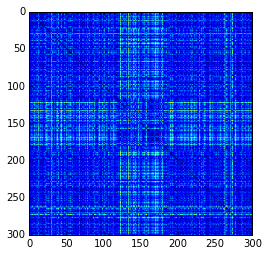

In [58]:
plt.figure()
plt.imshow(D)
plt.show()

Just by visual inspection, we see that $D$ has a very specific structure and the interval with the extreme
is easy to recognize as a small block structure in the middle. This allows us to derive a very simple algorithm for
multivariate extreme detection.

#### Novelty detection by finding the right block structure in the distance matrix
Given a matrix $D \in \mathbb{R}^{n \times n}$, the idea is to find an interval $[a,b)$ in the time series (having $n$ time steps) that minimizes the mean distance between extreme points and the mean distance between non-extreme points as well as maximizing the distance between extreme and non-extreme points:

$\text{argmin}_{a<b} \quad \frac{1}{n^2 - m}(\sum\limits_{i \in [a,b), j \in [a,b)} d_{i,j} + \sum\limits_{i \notin [a,b), j \notin [a,b)} d_{i,j}) - \frac{\alpha}{m} (\sum\limits_{i \in [a,b), j \notin [a,b)} d_{i,j} + \sum\limits_{i \notin [a,b), j \in [a,b)} d_{i,j})$

where $m = (j-i) \cdot (n-j+i)$ is the number of pairs of extreme and non-extreme points and $\alpha$ is some free parameter to balance both criteria. The above criterion can be rewritten in multiple ways to save computation time, but we come to this later. Let us first write a very simple greedy optimization version for finding this interval.

In [59]:
def find_extreme_interval_nonefficient(D, alpha=1.0, extint_min_len = 20, extint_max_len = 150):
    """ Finding an extreme interval by computing block matrix sums (O(n*span-of-possible-intervals*n*n)) """
    n = D.shape[0]
    
    # the minimal and maximal length of an extreme interval (extint_*_len)
    # this avoids trivial solutions of just one data point in the interval
    # and saves computation time in the current version (not necessary for an efficient
    # version)
    min_objective = None
    # sum of all elements of D
    sum_D = np.sum(D)
    # loop through all possible intervals
    for i in range(n-extint_min_len):
        for j in range(i+extint_min_len, min(i+extint_max_len,n)):
            # compute the second term of the above sum
            interclass = 2*np.sum(D[i:j,:]) - 2*np.sum(D[i:j,i:j])
            scale_interclass = 2*(j - i)*(n - j + i)
            # compute the first term of the above sum
            intraclass = sum_D - interclass
            scale_intraclass = n*n - scale_interclass
            # compute the objective
            objective = - interclass/scale_interclass + alpha * intraclass/scale_intraclass
            if min_objective is None or objective < min_objective:
                min_objective = objective
                a = i
                b = j
    return (a,b)

Let's write an efficient version with integral matrices to compute the sums in $\mathbf{D}$ with just a few operations.

In [60]:
def integral_matrix(A):
    return np.cumsum(np.cumsum(A, axis=0), axis=1)

With the cumsum method of numpy, computing the integral image is a piece of cake :)

In [61]:
%time D_integral = integral_matrix(D)

CPU times: user 1e+03 µs, sys: 0 ns, total: 1e+03 µs
Wall time: 564 µs


In [62]:
def find_extreme_interval(D, alpha=1.0, extint_min_len = 20, extint_max_len = 150):
    """ Finding an extreme interval by computing block matrix sums (O(n*span-of-possible-intervals)) """
    # the minimal and maximal length of an extreme interval (extint_*_len)
    # this avoids trivial solutions of just one data point in the interval
    # and saves computation time in the current version (not necessary for an efficient
    # version)
    D_integral = integral_matrix(D)
    n = D_integral.shape[0]
    
    min_objective = None
    # sum of all elements of D
    endelement = -1
    sum_D = D_integral[endelement, endelement]
    # loop through all possible intervals
    for i in range(n-extint_min_len):
        for j in range(i+extint_min_len, min(i+extint_max_len,n)):
            # compute the second term of the above sum
            # the following three lines are the only difference to the non-efficient version
            sumD_I_All = D_integral[j-1, endelement] - D_integral[i-1, endelement]
            sumD_I_I = D_integral[j-1, j-1] - D_integral[i-1, j-1] - D_integral[j-1, i-1] + D_integral[i-1, i-1]
            interclass = 2*sumD_I_All - 2*sumD_I_I
            scale_interclass = 2*(j - i)*(n - j + i)
            # compute the first term of the above sum
            intraclass = sum_D - interclass
            scale_intraclass = n*n - scale_interclass
            # compute the objective
            objective = - interclass/scale_interclass + alpha * intraclass/scale_intraclass
            if min_objective is None or objective < min_objective:
                min_objective = objective
                a = i
                b = j
    return (a,b)

We assumed that data points are similar to each other in the extreme interval. For certain applications, this does not have to be true and the objective could be modified accordingly. Let's try this algorithm on the matrix from above with a magic parameter $\alpha$. For $\alpha=1.0$, we would get the same result by the way.

In [65]:
%load_ext line_profiler
%time a, b = find_extreme_interval_nonefficient(D, 10.0)
print a,b
#%lprun -f find_extreme_interval a, b = find_extreme_interval(D, 10.0)
%time a, b = find_extreme_interval(D, 10.0)
print a,b

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
CPU times: user 580 ms, sys: 0 ns, total: 580 ms
Wall time: 578 ms
122 180
CPU times: user 48 ms, sys: 0 ns, total: 48 ms
Wall time: 48.1 ms
122 180


Let's plot the matrix again with the interval

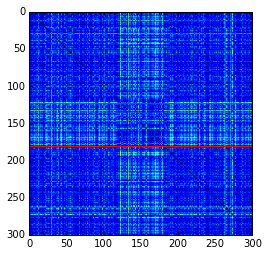

In [64]:
def plot_matrix_with_interval(D, a, b):
    plt.figure()
    plt.plot(range(D.shape[0]), a*np.ones([D.shape[0],1]), 'r-')
    plt.plot(range(D.shape[0]), b*np.ones([D.shape[0],1]), 'r-')
    plt.imshow(D)
    plt.show()
    
plot_matrix_with_interval(D, a, b)

Wow, this worked nicely. However, the example was rather easy. Let's try a more complex one.

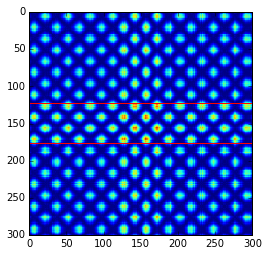

In [9]:
D = load_matrix('testMACchange.h5')
a, b = find_extreme_interval_nonefficient(D, 10.0)
plot_matrix_with_interval(D, a, b)

**This looks nice as well although we have a seasonal cycle here.**

#### Novelty detection by finding by minimizing the KL divergence
The last approach was nice but lacked a proper theoretical motivation. In the following, we will derive a similar algorithm based on Kullback-Leibler (KL) divergence between the distribution $p_I$ of data points in the extreme interval $I = [a,b)$ and the distribution $p_{\Omega}$ of non-extreme data points. We approximate both distributions with a simple kernel density estimate:

$p_I(\mathbf{x}) = \frac{1}{|I|} \sum\limits_{i \in I} K(\mathbf{x}, \mathbf{x}_i)$

with $K$ being a normalized kernel, such that $p_I$ is a proper densitity. Similarly, we define $p_{\Omega}$ with $\Omega = \{1, \ldots, n\} \setminus I$.

Let's first compute the kernel matrix from our squared Euclidean distances in $D$.

In [11]:
# compute the squared Euclidean distances by ourselves
#X = load_matrix('cube_kb0.0kn_0.0_ks2.0_lat41_lon41.h5', 'datacube')
#from scipy.spatial.distance import pdist, squareform
#D = squareform(pdist(X.T, 'sqeuclidean'))
D = load_matrix('testSimpleShift.h5')
dimension = 10
# compute proper normalized Gaussian kernel values
kernel_sigma_sq = 1.0
K = np.exp(-D/2.0)/((2*np.pi*kernel_sigma_sq)**(dimension/2)) 

Ok, well done (maybe). Let's derive the algorithm where we try to maximize the KL divergence between the two distributions:

$\text{KL}^{\alpha}(p_{\Omega}, p_I) = \frac{1}{n} \sum\limits_{i=1}^n p_{\Omega}(\mathbf{x}_i) \log \frac{ p_{I}^{\alpha}(\mathbf{x}_i) }{ p_{\Omega}(\mathbf{x}_i) } = \frac{1}{n} \sum\limits_{i=1}^n p_{\Omega}(\mathbf{x}_i) \log p_{I}^{\alpha}(\mathbf{x}_i) - \frac{1}{n} \sum\limits_{i=1}^n p_{\Omega}(\mathbf{x}_i) \log ( p_{\Omega}(\mathbf{x}_i) ) $

The above formulation uses a parameterized version of the KL divergence (which will be important to get the right results).
However, one should use something like the power divergence (http://link.springer.com/article/10.1007/s13571-012-0050-3) or the density power divergence (http://biomet.oxfordjournals.org/content/85/3/549.full.pdf).
Plugging everything together we derive at the following algorithm:


In [12]:
def find_extreme_interval_kldivergence(K, mode="OMEGA_I", alpha=1.0, extint_min_len = 20, extint_max_len = 150):
    n = K.shape[0]
    
    # small constant to avoid problems with log(0)
    eps = 1e-7
    
    # sum of all kernel values
    sums_all = np.sum(K, axis=0)
    
    min_negative_kl = None
    # loop through all possible intervals
    for i in range(n-extint_min_len):
        for j in range(i+extint_min_len, min(i+extint_max_len,n)):
            extreme_interval_length = j-i
            non_extreme_points = n - extreme_interval_length
            # sum up kernel values to get non-normalized
            # kernel density estimates at single points for p_I and p_Omega
            sums_extreme = np.sum(K[i:j,:], axis=0)
            sums_non_extreme = sums_all - sums_extreme
            
            negative_kl = 0.0
            # the mode parameter determines which KL divergence to use
            # mode == SYM does not make much sense right now for alpha != 1.0
            if mode == "OMEGA_I" or mode == "SYM":
                # version for maximizing KL(p_Omega, p_I)
                kl_integrand1 = np.mean(np.log(sums_extreme/extreme_interval_length + eps) * 
                                               sums_non_extreme/non_extreme_points)
                kl_integrand2 = np.mean(np.log(sums_non_extreme/non_extreme_points + eps) * 
                                               sums_non_extreme/non_extreme_points)
                negative_kl_Omega_I = alpha * kl_integrand1 - kl_integrand2
                negative_kl += negative_kl_Omega_I
            
            # version for maximizing KL(p_I, p_Omega)
            if mode == "I_OMEGA" or mode == "SYM":
                kl_integrand1 = np.mean(np.log(sums_non_extreme/non_extreme_points + eps) * 
                                        sums_extreme/extreme_interval_length)
                kl_integrand2 = np.mean(np.log(sums_extreme/extreme_interval_length + eps) * 
                                        sums_extreme/extreme_interval_length)
                negative_kl_I_Omega = alpha * kl_integrand1 - kl_integrand2
                negative_kl += negative_kl_I_Omega
            
            if min_negative_kl is None or negative_kl < min_negative_kl:
                min_negative_kl = negative_kl
                a = i
                b = j
    
    return a,b

Open questions:
    
1. Which version of the KL divergence works best?
2. Is the above code really correct?
3. The code above should be optimized (this is possible!)

Let's try the algorithm with the computed kernel matrix.

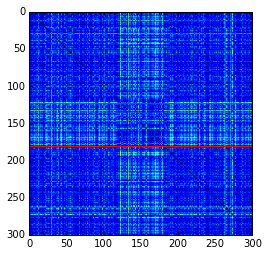

122 180


In [13]:
a, b = find_extreme_interval_kldivergence(K, "OMEGA_I", 3.0)
plot_matrix_with_interval(D, a, b)
print a,b

**Wow, this works again**. However, it does not work perfectly for $\alpha=1.0$, also known as standard KL divergence.

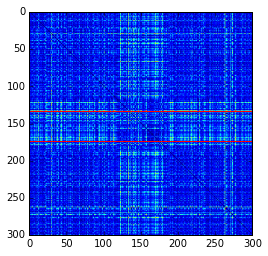

In [14]:
a, b = find_extreme_interval_kldivergence(K, "OMEGA_I", 1.0)
plot_matrix_with_interval(D, a, b)

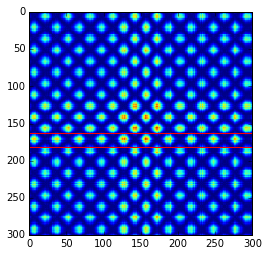

In [16]:
D = load_matrix('testMACchange.h5')
K = np.exp(-D/2.0)/((2*np.pi*kernel_sigma_sq)**(dimension/2)) 
a, b = find_extreme_interval_kldivergence(K, "OMEGA_I", 3.0)
plot_matrix_with_interval(D, a, b)

What a bumper, this needs further investigation and likely proper parameterized KL divergences (which are not super difficult to implement)

### Further remarks, ideas, FAQs

1. "Isn't this approach total inefficient since we need to compute kernels and stuff?": Currently, the asymptotic time is indeed quadratic (in an efficient still non-implemented version), but the general theoretical idea of maximizing KL divergences can also be used for multivariate Gaussian distributions p_I and p_Omega. In this case there is even a closed-form solution for the KL divergence (see wikipedia) which relies on the covariance matrices of the current interval and the rest. These matrices can be efficiently estimated and updated. Voila, we should have a wonderful large-scale approach.

2. The above algorithm requires $O(n^2 \cdot (\texttt{extint_max_length} - \texttt{extint_min_length})^2$ operations! This is just the case because I implemented it in a naive but straight forward manner without any optimizations. The above code can be optimized to have only $O(n^2)$ operations at maximum.

3. **"What would be the next steps?"** (a) test both of the algorithms on the whole dataset, (b) implement a power density divergence version of the algorithm (c) try it (d) if the algorithm takes too long, implement the multivariate Gaussian version (see item 1) (e) write a paper :)